In [4]:
import sys
sys.path.append('..')
from Comms_System import Comms_System, SNR_plot
import numpy as np
import matplotlib.pyplot as plt
from ML_components import load_params
from Network import NeuralNetwork
import scipy
import torch
from filters import butter_lowpass

In [5]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 10000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)

In [6]:
def ideal_lpf(Tx, cutoff_freq):
    Tx_freq = torch.fft.rfft(Tx)
    xf = torch.fft.rfftfreq(Tx.shape[0], 1/8)
    Tx_freq[xf > cutoff_freq] = 0
    Tx_low = torch.fft.irfft(Tx_freq, n=Tx.shape[0])
    return Tx_low

In [12]:
#cutoffs = ['2', '1', '06', '05']
#cutoff_ints = [2, 1, 0.6, 0.5]
cutoffs = ['06']
cutoff_ints = [0.6]
#figsize=(6.4, 4.8)
figsize=(13, 8)

In [13]:
def plot_time_response(responses, legend, title, savefig=None):
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=20)
    for response in responses:
        plt.plot(response)
    plt.ylabel('Amplitude', fontsize=16)
    plt.legend(legend)
    plt.grid(True)
    if savefig is not None:
        plt.savefig(savefig)
    else:
        plt.show()

def plot_freq_response(responses, legend, title, savefig=None, ylim=[-70, -20]):
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=20)
    for response in responses:
        if len(responses) == 1:
            plt.magnitude_spectrum(response, Fs=8, sides='twosided', scale='dB', color='C1')
        else:
            plt.magnitude_spectrum(response, Fs=8, sides='twosided', scale='dB')
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Magnitude (dB)', fontsize=16)
    plt.ylim(ylim)
    plt.legend(legend)
    plt.grid(True)
    if savefig is not None:
        plt.savefig(savefig)
    else:
        plt.show()

# Inspect learned filters from Joint Training

### Sender Weights

Cutoff Frequency = 0.6


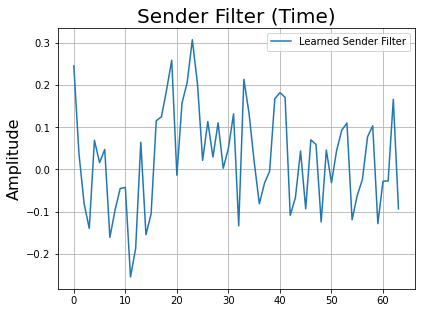

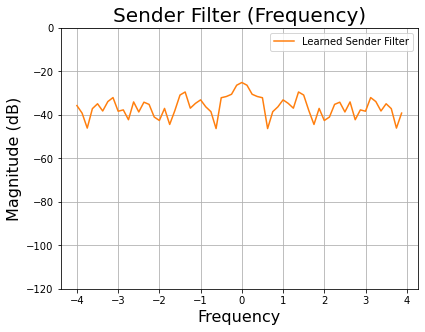

_________________________________________________________



In [14]:
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0)
figsize = (6.4, 4.8)

for cutoff, c_int in zip(cutoffs, cutoff_ints):
    print('Cutoff Frequency =', c_int)
    path = '../Joint_Models/'
    net = torch.load(path + 'SenderIdeal' + cutoff)
    
    learned_filter = list(net.parameters())[0].detach()[0][0]
    learned_filter = learned_filter / torch.sqrt(torch.sum(torch.square(learned_filter))) # normalize
    
    plot_time_response([learned_filter], legend=['Learned Sender Filter'], title='Sender Filter (Time)')
    plot_freq_response([learned_filter], legend=['Learned Sender Filter'], title='Sender Filter (Frequency)', ylim=[-120,0])

    print('_________________________________________________________')
    print()

### Receiver Weights

Cutoff Frequency = 0.6


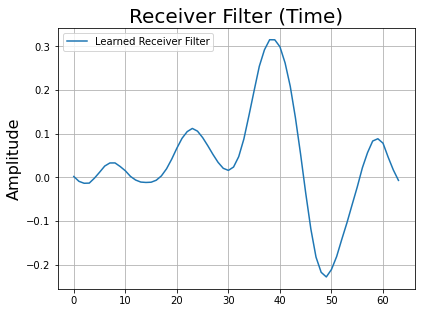

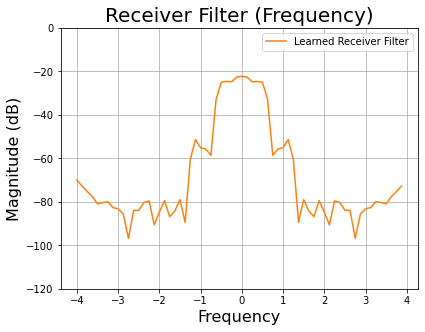

_________________________________________________________



In [15]:
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0)
figsize = (6.4, 4.8)

for cutoff, c_int in zip(cutoffs, cutoff_ints):
    print('Cutoff Frequency =', c_int)
    path = '../Joint_Models/'
    net = torch.load(path + 'ReceiverIdeal' + cutoff)
    
    learned_filter = list(net.parameters())[0].detach()[0][0]
    learned_filter = learned_filter / torch.sqrt(torch.sum(torch.square(learned_filter))) # normalize
    
    plot_time_response([learned_filter], legend=['Learned Receiver Filter'], title='Receiver Filter (Time)')
    plot_freq_response([learned_filter], legend=['Learned Receiver Filter'], title='Receiver Filter (Frequency)', ylim=[-120,0])

    print('_________________________________________________________')
    print()

### Total Impulse Response of Sender (i.e. sender filter convolved with LPF)

Cutoff Frequency = 0.6


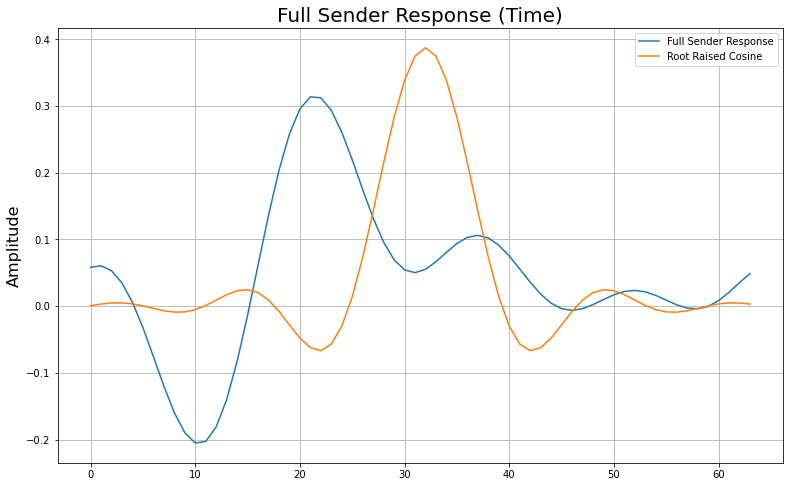

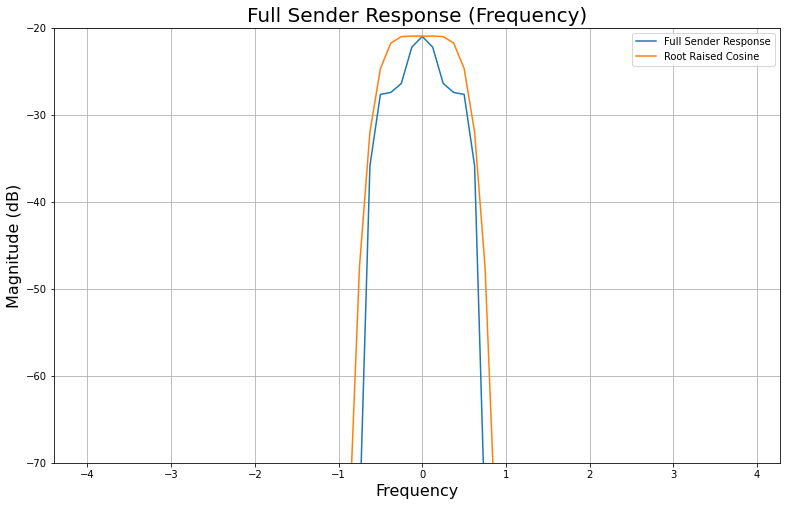

_________________________________________________________



In [17]:
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
#figsize = (6.4, 4.8)
figsize = (13, 8)

for cutoff, c_int in zip(cutoffs, cutoff_ints):
    print('Cutoff Frequency =', c_int)
    path = '../Joint_Models/'
    net = torch.load(path + 'SenderIdeal' + cutoff)
        
    learned_filter = list(net.parameters())[0].detach()[0][0]
    learned_filter = learned_filter / torch.sqrt(torch.sum(torch.square(learned_filter))) # normalize
    
    total_sender_response = ideal_lpf(learned_filter, c_int)
    total_sender_response = total_sender_response / torch.sqrt(torch.sum(torch.square(total_sender_response))) # normalize
    total_sender_response = total_sender_response.detach().numpy()
    root_raised = CS.h / np.sqrt(np.sum(np.square(CS.h)))


    plot_time_response([total_sender_response, root_raised], legend=['Full Sender Response', 'Root Raised Cosine'],
                      title='Full Sender Response (Time)')
    plot_freq_response([total_sender_response, root_raised], legend=['Full Sender Response', 'Root Raised Cosine'], 
                       title='Full Sender Response (Frequency)', ylim=[-70,-20])

    print('_________________________________________________________')
    print()

## Plot Sender Response with RRCos for multiple beta values

In [ ]:
#figsize = (6.4, 4.8)
figsize = (13, 8)

betas = [0, 0.35, 0.7, 1]

for cutoff, c_int in zip(cutoffs, cutoff_ints):
    print('Cutoff Frequency =', c_int)
    path = '../Joint_Models/'
    net = torch.load(path + 'SenderIdeal' + cutoff)
        
    learned_filter = list(net.parameters())[0].detach()[0][0]
    learned_filter = learned_filter / torch.sqrt(torch.sum(torch.square(learned_filter))) # normalize
    
    total_sender_response = ideal_lpf(learned_filter, c_int)
    total_sender_response = total_sender_response / torch.sqrt(torch.sum(torch.square(total_sender_response))) # normalize
        
    plt.figure(figsize=figsize)
    plt.title('Full Sender Response and Root Raised Cosine', fontsize=20)
    plt.magnitude_spectrum(total_sender_response, Fs=8, sides='twosided', scale='dB', linewidth=5)
    # plt.plot(total_sender_response)
    for beta in betas:
        CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=beta)
        root_raised = CS.h / np.sqrt(np.sum(np.square(CS.h)))
        plt.magnitude_spectrum(root_raised, Fs=8, sides='twosided', scale='dB')
        # plt.plot(root_raised)
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Magnitude (dB)', fontsize=16)
    plt.ylim([-70, -20])
    legend = ['Learned Sender Response'] + ['RRC alpha=' + str(beta) for beta in betas]
    plt.legend(legend, fontsize=12)
    plt.grid(True)
    plt.show()
    print('_________________________________________________________')
    print()

### Total Response of Whole System

Cutoff Frequency = 0.7


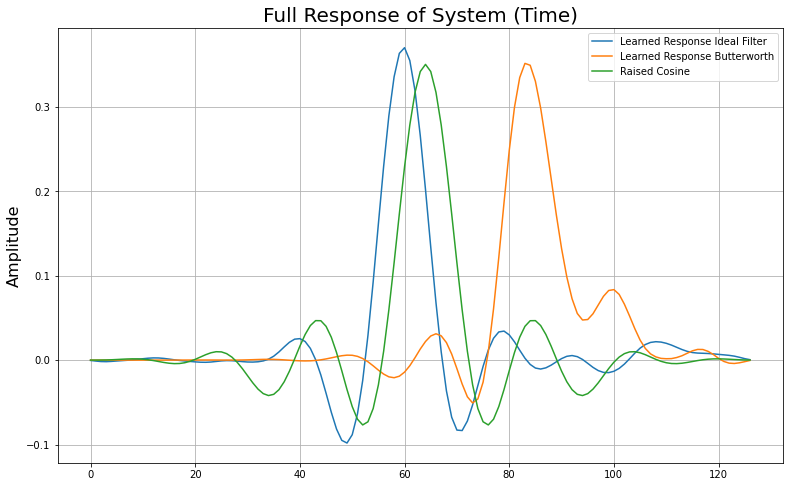

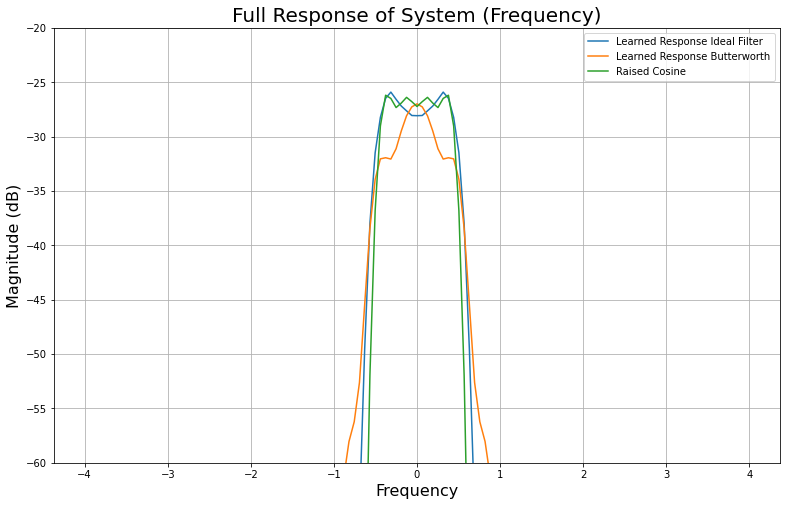

_________________________________________________________



In [23]:
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0)
#figsize = (6.4, 4.8)
figsize = (13, 8)
betas = [0, 0.35, 0.7, 1]
cutoffs = ['07']
cutoff_ints = [0.7]

for cutoff, c_int in zip(cutoffs, cutoff_ints):
    b, a = butter_lowpass(cutoff_freq=0.675, sampling_rate=CS.m, order=10)
    print('Cutoff Frequency =', c_int)
    path = '../Joint_Models/'
    tx_net = torch.load(path + 'SenderIdeal'+cutoff)
    rx_net = torch.load(path + 'ReceiverIdeal'+cutoff)
    tx_net_butter = torch.load(path + 'SenderButter0.675')
    rx_net_butter = torch.load(path + 'ReceiverButter0.675')
    
    learned_tx_filter = list(tx_net.parameters())[0].detach()[0][0]
    learned_rx_filter = list(rx_net.parameters())[0].detach()[0][0]
    learned_tx_filter_butter = list(tx_net_butter.parameters())[0].detach()[0][0]
    learned_rx_filter_butter = list(rx_net_butter.parameters())[0].detach()[0][0]
    
    total_sender_response = ideal_lpf(learned_tx_filter, c_int)
    total_sender_response_butter = scipy.signal.lfilter(b, a, learned_tx_filter_butter)
    
    total_sender_response = total_sender_response / torch.sqrt(torch.sum(torch.square(total_sender_response))) # normalize
    total_sender_response = total_sender_response.detach().numpy()
    total_sender_response_butter /= np.sqrt(np.sum(np.square(total_sender_response_butter)))
    learned_rx_filter = learned_rx_filter.detach().numpy()
    
    raised_cosine = np.convolve(CS.h, CS.h)
    raised_cosine /= np.sqrt(np.sum(np.square(raised_cosine)))
    
    full_response = np.convolve(total_sender_response, learned_rx_filter)
    full_response = full_response / np.sqrt(np.sum(np.square(full_response))) # normalize
    full_response_butter = np.convolve(total_sender_response_butter, learned_rx_filter_butter)
    full_response_butter /= np.sqrt(np.sum(np.square(full_response_butter))) # normalize
    
    
    plot_time_response([-full_response, -full_response_butter, raised_cosine], 
                       legend=['Learned Response Ideal Filter', 'Learned Response Butterworth', 'Raised Cosine'],
                      title='Full Response of System (Time)')
    plot_freq_response([-full_response, -full_response_butter, raised_cosine], 
                        legend=['Learned Response Ideal Filter', 'Learned Response Butterworth', 'Raised Cosine'],
                       title='Full Response of System (Frequency)', ylim=[-60, -20])
    print('_________________________________________________________')
    print()

## Plot Full Response with Raised Cosine for multiple beta values

In [ ]:
#figsize = (6.4, 4.8)
figsize = (13, 8)

betas = [0, 0.35, 0.7, 1]

for cutoff, c_int in zip(cutoffs, cutoff_ints):
    print('Cutoff Frequency =', c_int)
    path = '../Joint_Models/'
    net = torch.load(path + 'SenderIdeal' + cutoff)
        
    learned_filter = list(net.parameters())[0].detach()[0][0]
    learned_filter = learned_filter / torch.sqrt(torch.sum(torch.square(learned_filter))) # normalize
    
    total_sender_response = ideal_lpf(learned_filter, c_int)
    total_sender_response = total_sender_response / torch.sqrt(torch.sum(torch.square(total_sender_response))) # normalize
    
    full_response = np.convolve(total_sender_response, learned_rx_filter)
    full_response = full_response / np.sqrt(np.sum(np.square(full_response))) # normalize
        
    plt.figure(figsize=figsize)
    plt.title('Full Sender Response and Root Raised Cosine', fontsize=20)
    plt.magnitude_spectrum(full_response, Fs=8, sides='twosided', scale='dB', linewidth=5)
    
    # plt.plot(total_sender_response)
    for beta in betas:
        CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=beta)
        raised_cosine = np.convolve(CS.h, CS.h)
        raised_cosine /= np.sqrt(np.sum(np.square(raised_cosine)))
        plt.magnitude_spectrum(raised_cosine, Fs=8, sides='twosided', scale='dB')
        # plt.plot(root_raised)
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Magnitude (dB)', fontsize=16)
    plt.ylim([-70, -20])
    legend = ['Learned Response'] + ['Raised Cosine alpha=' + str(beta) for beta in betas]
    plt.legend(legend)
    plt.grid(True)
    plt.show()
    print('_________________________________________________________')
    print()